In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc
# import squidpy as sq

import tumorevo

# Introduction to `tumorevo.tumorsample`
In this notebook we generate bulk DNA, scDNA, scRNA and Visium data from a simulated tumor, and perform basic analyses as we would on real data.

In [79]:
tumor_path = '/Users/pedrof/PhD/projects/main/tumorevo/sim_out/'

## Take a biopsy of the tumor
Before generating data, we must obtain material. `tumorevo.tumorsample.biopsy` simulates this process whereby the whole or a chunk of the tumor is obtained. Here we will first create a cell suspension from 80\% of the tumor sampled uniformly from its 2D structure, and then create a Visium slide on the whole 2D tissue for spatial transcriptomics.

In [80]:
# True genomes, transcriptomes, types and spatial coordinates of all cells
cell_data_path = os.path.join(tumor_path, 'cell_data_0')
cell_data = dict(cell_snv=pd.read_csv(os.path.join(cell_data_path, 'cell_snv.csv'), index_col=0),
                 cell_exp=pd.read_csv(os.path.join(cell_data_path, 'cell_exp.csv'), index_col=0),
                 cell_crd=pd.read_csv(os.path.join(cell_data_path, 'cell_crd.csv'), index_col=0),
                 cell_ids=pd.read_csv(os.path.join(cell_data_path, 'cell_ids.csv'), index_col=0)
)
# cell_types = 
tissue = pd.read_csv(os.path.join(tumor_path, 'grid_0.csv'), index_col=0, dtype=str)

In [81]:
drivers = pd.read_csv(os.path.join(tumor_path, 'gene_data', 'driver_types.csv'), index_col=0)

In [82]:
np.where(drivers==1)[0]

array([ 15,  27,  99, 106, 108, 118, 127, 128, 165, 220, 222, 249, 257,
       263, 272, 273, 280, 290, 323, 349, 353, 379, 381, 395, 444, 459,
       479, 489, 492, 529, 551, 557, 625, 635, 658, 670, 673, 684, 690,
       728, 740, 788, 823, 878, 918, 949])

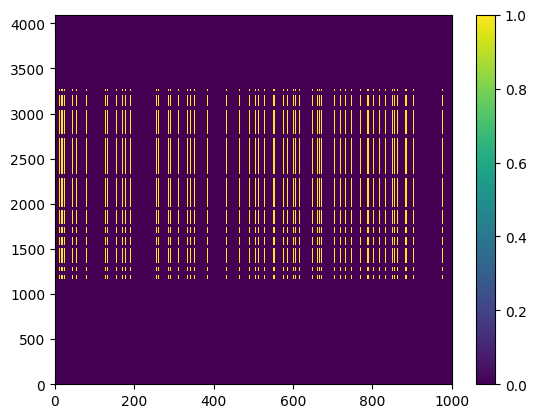

In [83]:
plt.pcolormesh(cell_data['cell_snv'])
plt.colorbar()
plt.show()

In [84]:
sampled_cell_ids = tumorevo.tumorsample.biopsy.sample(cell_data['cell_snv'].index, fraction=.8)

In [85]:
cell_data['cell_snv'][:10]

,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,...,G990,G991,G992,G993,G994,G995,G996,G997,G998,G999
C0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Bulk DNA-sequencing data

In [28]:
bdna_assay = tumorevo.tumorsample.assays.bulkDNA(data_mode='counts', n_reads=100000, fpr=0.00, fnr=0.000, target_genes='all')
bdna_assay.run(cell_data)

In [29]:
bdna_assay.observed_data

,coverage,alt_counts
G0,100,67
G1,116,76
G2,105,0
G3,93,0
G4,105,0
...,...,...
G995,76,0
G996,104,0
G997,115,76
G998,98,68


### Variant allele frequency (VAF)

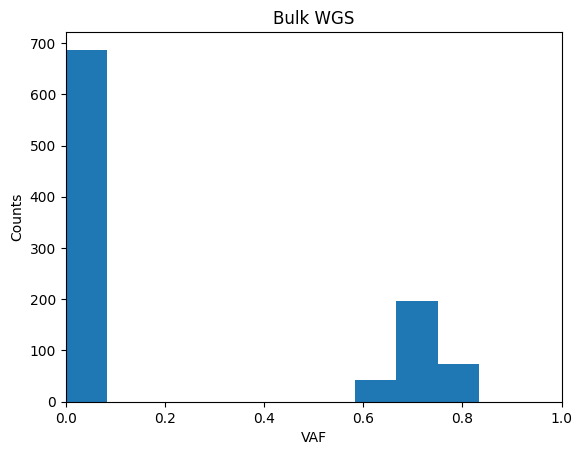

In [30]:
vafs = bdna_assay.observed_data['alt_counts']/bdna_assay.observed_data['coverage']
plt.hist(vafs)
plt.xlim([0,1])
plt.xlabel("VAF")
plt.ylabel("Counts")
plt.title("Bulk WGS")
plt.show()

### Cancer cell fraction (CCF)

### Detecting clones: cluster the CCFs

### Reconstructing the phylogeny 
To reconstruct the evolutionary history of the clones from bulk data, we must rely on the following principles:
* infinite sites hypothesis: a mutation can occur strictly once in evolution,
* the pigeonhole principle: the combined CCF of branching subclones must not be higher than that of their shared parent clone (otherwise they are linear),
* crossing rule: if a clone has a higher CCF than another clone in one sample, but the opposite is true in another sample, the clones must be branching.

## Single-cell DNA-sequencing data

In [22]:
scdna_assay = tumorevo.tumorsample.assays.scDNA(data_mode='counts', n_reads=100, fpr=0.001, fnr=0.0001, target_genes='all')
scdna_assay.run(cell_data)

In [23]:
scdna_assay.coverage

,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,...,G90,G91,G92,G93,G94,G95,G96,G97,G98,G99
C1570,2,1,2,1,2,0,0,4,0,1,...,0,0,0,0,0,2,0,2,0,0
C2468,2,1,2,0,2,0,2,0,2,0,...,0,1,0,0,2,1,3,0,1,3
C1050,0,1,1,2,1,0,0,0,0,2,...,1,1,0,1,0,1,1,1,0,2
C1519,0,1,2,0,2,0,3,2,0,0,...,0,1,1,1,1,1,1,0,0,0
C545,3,2,1,3,1,2,0,0,0,2,...,1,0,4,0,0,2,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2833,1,0,1,1,1,2,0,0,0,0,...,2,0,0,2,2,0,1,1,1,1
C2367,2,0,0,1,0,1,1,0,0,2,...,0,3,0,0,1,2,1,1,2,0
C858,1,1,1,1,2,2,0,0,1,0,...,1,0,0,3,1,0,1,0,0,1
C268,1,0,0,1,2,1,1,0,1,1,...,0,1,0,0,1,1,0,1,1,1


In [24]:
scdna_assay.alt_counts

,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,...,G90,G91,G92,G93,G94,G95,G96,G97,G98,G99
C1570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C2468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1519,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
C545,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C2367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C858,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Quality control
Remove genes and cells with poor coverage.

### Mutation calling
With per-cell read counts, we can actually try to call mutations and binarize these matrices.

### Cell clustering to find subclones

### Reconstructing the phylogeny

## Single-cell RNA-sequencing data


In [35]:
scrna_assay = tumorevo.tumorsample.assays.scRNA(n_reads=1000, n_cells=1000)
scrna_assay.run(cell_data)

In [40]:
adata = ad.AnnData(scrna_assay.observed_counts)

In [45]:
adata

AnnData object with n_obs × n_vars = 1000 × 1000

### Quality control
Remove cells and genes with low UMI counts.

In [46]:
sc.pp.calculate_qc_metrics(
    adata, inplace=True, log1p=True
)

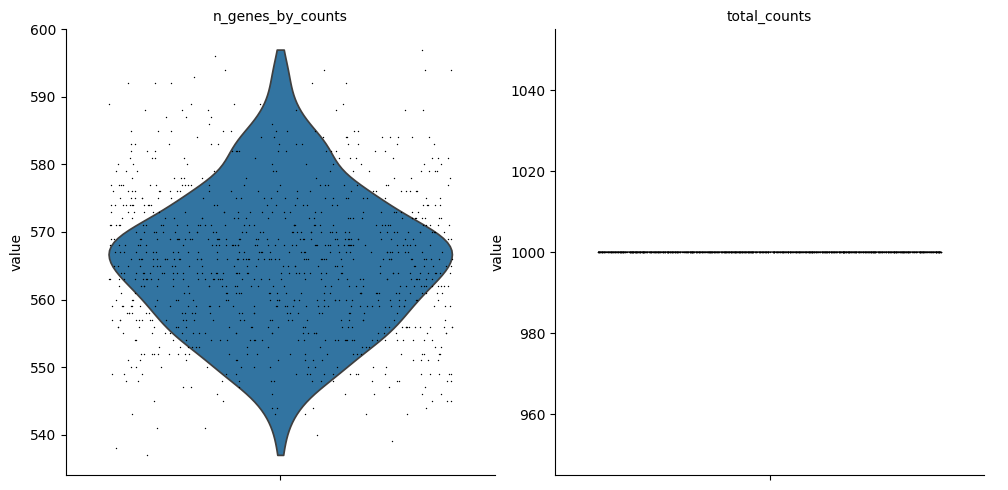

In [48]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

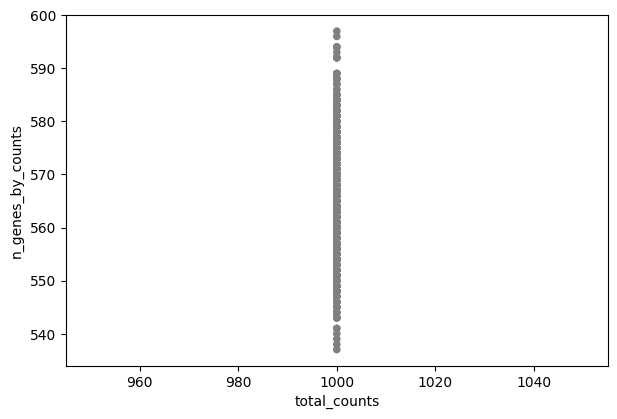

In [49]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts")

In [50]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [51]:
adata

AnnData object with n_obs × n_vars = 1000 × 1000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Normalizing and filtering

In [52]:
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

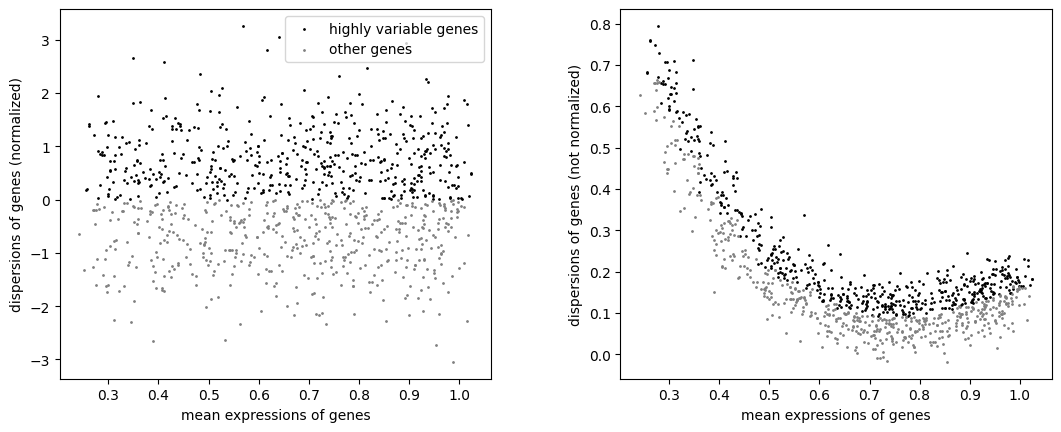

In [53]:
sc.pp.highly_variable_genes(adata, n_top_genes=500)
sc.pl.highly_variable_genes(adata)

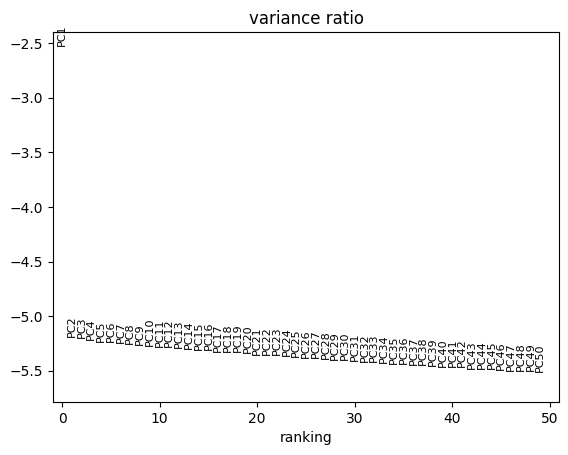

In [54]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)


### Clustering and visualization

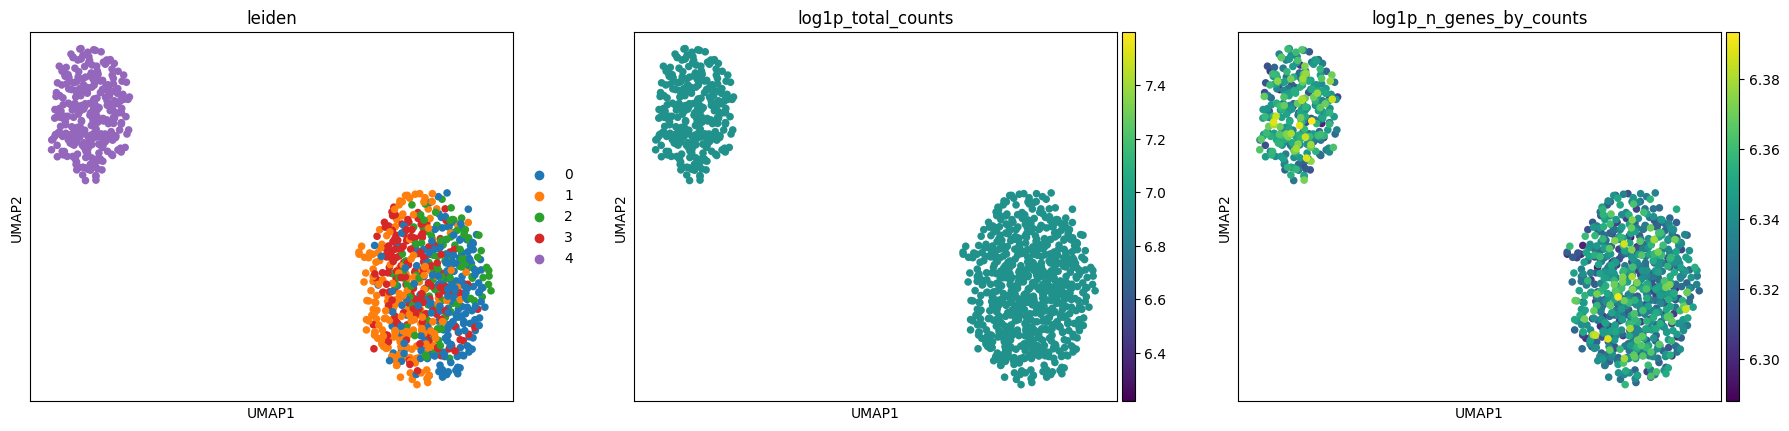

In [74]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "log1p_n_genes_by_counts"],
    ncols=3,
)

### Differential expression

In [56]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")


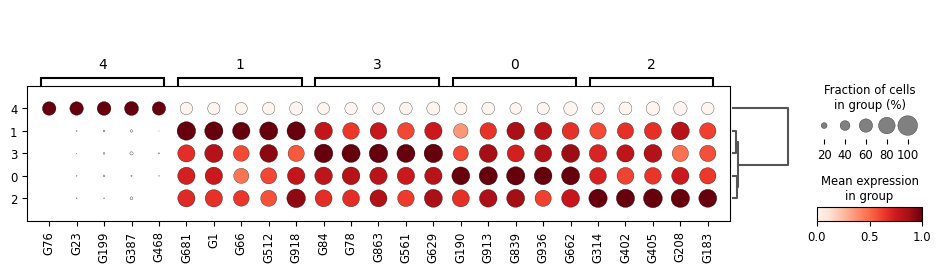

In [57]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)

## Visium data

In [86]:
tissue.shape[0]

50

In [87]:
visium_assay = tumorevo.tumorsample.assays.Visium(n_reads=5000, n_spots_row=20, n_spots_col=20, spot_radius=2.)
visium_assay.run(cell_data, grid_side=tissue.shape[0])

(400,)


In [88]:
adata = ad.AnnData(visium_assay.spot_umi)

In [89]:
adata.obsm["spatial"] = visium_assay.spot_crd[['col','row']].values
adata.obs['spot_cell_counts'] = visium_assay.spot_cell_counts

from PIL import Image
import numpy as np
source_image_path = os.path.join("/Users/pedrof/PhD/projects/main/tumorevo/fig_out/", "slice.png")

im = Image.open(source_image_path)
image = np.array(im)

spatial_key = "spatial"
library_id = "A1"

adata.uns[spatial_key] = {library_id: {}}
adata.uns[spatial_key][library_id]["images"] = {}
adata.uns['spatial'][library_id]['images']['hires'] = image#.astype(np.float32)
adata.uns[spatial_key][library_id]["scalefactors"] = {}
adata.uns['spatial'][library_id]['scalefactors']['tissue_hires_scalef'] = image.shape[0] / np.max(tissue.shape)
adata.uns['spatial'][library_id]['scalefactors']['spot_diameter_fullres'] = visium_assay.spot_radius*1

In [90]:
drivers.iloc[np.where(drivers==-1)[0]].index

Index(['G26', 'G69', 'G72', 'G123', 'G134', 'G180', 'G184', 'G223', 'G232',
       'G265', 'G279', 'G281', 'G306', 'G339', 'G340', 'G393', 'G420', 'G438',
       'G445', 'G471', 'G499', 'G516', 'G545', 'G558', 'G564', 'G598', 'G618',
       'G644', 'G688', 'G692', 'G713', 'G735', 'G742', 'G747', 'G755', 'G756',
       'G779', 'G797', 'G858', 'G863', 'G869', 'G881', 'G882', 'G890', 'G905',
       'G908', 'G909', 'G969', 'G974'],
      dtype='object')

In [91]:
drivers.iloc[np.where(drivers==1)[0]].index

Index(['G15', 'G27', 'G99', 'G106', 'G108', 'G118', 'G127', 'G128', 'G165',
       'G220', 'G222', 'G249', 'G257', 'G263', 'G272', 'G273', 'G280', 'G290',
       'G323', 'G349', 'G353', 'G379', 'G381', 'G395', 'G444', 'G459', 'G479',
       'G489', 'G492', 'G529', 'G551', 'G557', 'G625', 'G635', 'G658', 'G670',
       'G673', 'G684', 'G690', 'G728', 'G740', 'G788', 'G823', 'G878', 'G918',
       'G949'],
      dtype='object')

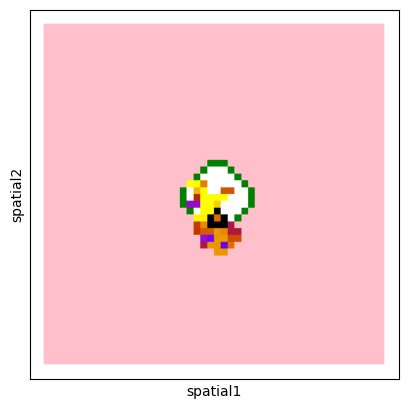

In [92]:
sc.pl.spatial(adata, img_key="hires", alpha_img=1)

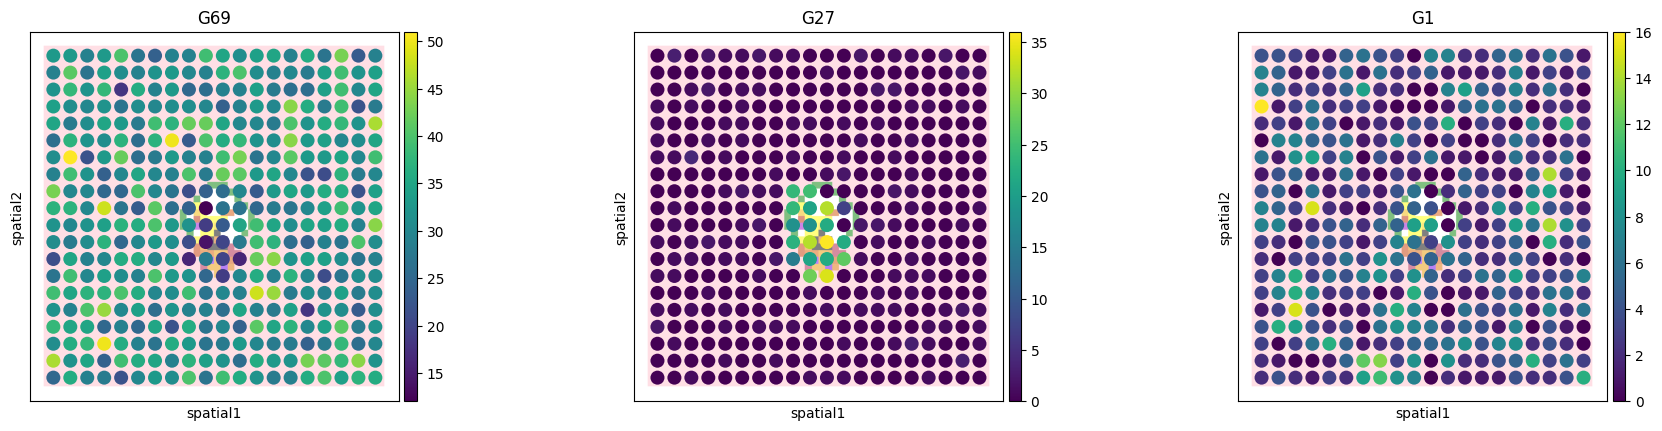

In [97]:
sc.pl.spatial(adata, img_key="hires", color=["G69", "G27", "G1"], alpha=1, alpha_img=.5)

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [ ]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

In [ ]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, flavor="igraph", directed=False, n_iterations=2
)

In [ ]:
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)


In [ ]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)


In [ ]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="leiden")
sq.pl.nhood_enrichment(adata, cluster_key="leiden")